In [3]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
def change_order(theta):
    order = np.argsort(theta[1,:])
    new_theta = np.zeros(theta.shape)
    for i in range(m):
        new_theta[0,i] = theta[0,order[i]]
        new_theta[1,i] = theta[1,order[i]]
    return new_theta

In [5]:
from src.mixture_poisson import poisson_random_param, sample_poisson, poisson_s_bar, poisson_theta_bar
from src.online_EM import online_EM,online_EM2
from src.batch_EM import batch_EM
n = 5000  # Size of the data set
m = 3
max_l = 100
l = [10, 40, 80]
p = [0.4, 0.35, 0.25]
theta_true = np.array([p, l])
print('Creating data set...')
Y, W = sample_poisson(n, l, p)
print('Data set created!\n')

Creating data set...
Data set created!



In [6]:
theta_true.shape

(2, 3)

/var/folders/mp/7hdt9f690cn5_pb85r6mcryh0000gn/T/ipykernel_35711/2457283754.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(Y,kde=True,bins=50)


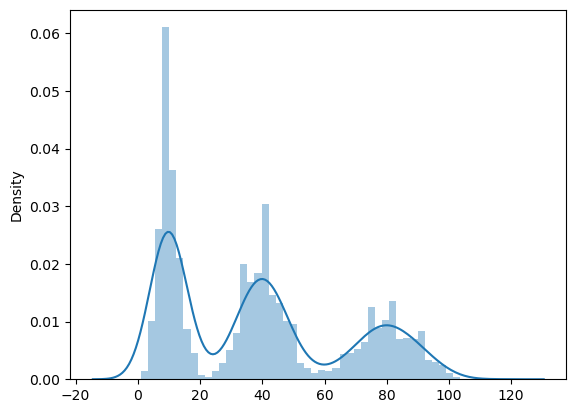

In [7]:
ax = sns.distplot(Y,kde=True,bins=50)

/var/folders/mp/7hdt9f690cn5_pb85r6mcryh0000gn/T/ipykernel_35711/1820905153.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(data[data['W']==i]['Y'],kde=False,norm_hist=False,\


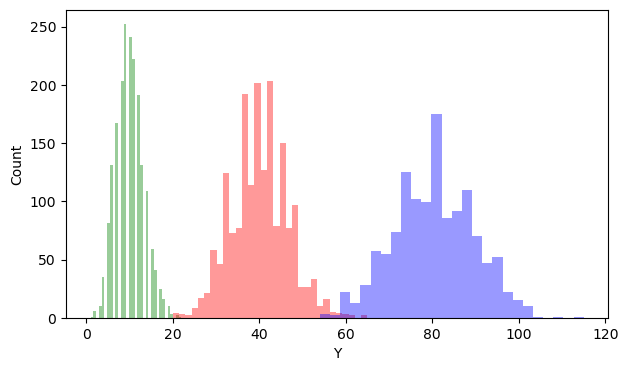

In [8]:
# visualize data set 
data = pd.DataFrame({'Y':Y,'W':W})
colors = ['g','r','b']

plt.figure(figsize=(7,4))
for i in range(m):
    ax = sns.distplot(data[data['W']==i]['Y'],kde=False,norm_hist=False,\
                      color = colors[i%len(colors)],label='Group{}'.format(i))
plt.ylabel('Count')
plt.savefig('poisson-data-dist.png')

### Online EM [Test 1]
alpha = [1.,0.6]

In [11]:
# Initialization
p_init, l_init = poisson_random_param(m, max_l)
# p_init = np.ones(m)/m
# l_init = max_l/2 * np.ones(m) + np.random.rand(3)
theta_init = np.array([p_init, l_init])
print(f"Initial Theta:\n{theta_init}")

# Stochastic Parameters
gamma_0 = [1, 1]
alphas = [1.3,0.6]
gamma1 = np.array([gamma_0[0] * np.power(l, -alphas[0]) for l in range(1, n+1)])
gamma2 = np.array([gamma_0[1] * np.power(l, -alphas[1]) for l in range(1, n+1)])
#gamma3 = np.array([gamma_0 * np.power(l, -alphas[2]) for l in range(1, n+1)])

Initial Theta:
[[ 0.18662985  0.60528546  0.20808469]
 [83.26615827 50.18396046 85.44020052]]


In [12]:
s_g1, theta_g1, all_theta_g1 = online_EM(Y, theta_init, gamma1, \
                                         poisson_s_bar, poisson_theta_bar, save_iter_theta = True)
s_g2, theta_g2, all_theta_g2 = online_EM(Y, theta_init, gamma2, \
                                         poisson_s_bar, poisson_theta_bar, save_iter_theta = True)
#s_g3, theta_g3, all_theta_g3 = online_EM(Y, theta_init, gamma3, \
                                         #poisson_s_bar, poisson_theta_bar, save_iter_theta = True)
print("\n===============\nFinal results \n===============")
print(f"Truth:\n{theta_true}")
print(f"Online EM with alpha {alphas[0]} after {n} iterations:\n{theta_g1}")
print(f"Online EM with alpha {alphas[1]} after {n} iterations:\n{theta_g2}")
#print(f"Online EM with alpha {alphas[2]} after {n} iterations:\n{theta_g3}")


Final results 
Truth:
[[ 0.4   0.35  0.25]
 [10.   40.   80.  ]]
Online EM with alpha 1.3 after 5000 iterations:
[[1.81140261e-07 9.99999759e-01 5.96027680e-08]
 [3.75084763e+01 3.75585395e+01 3.75049097e+01]]
Online EM with alpha 0.6 after 5000 iterations:
[[ 0.26481715  0.35745561  0.37772724]
 [81.01813344  9.74685872 40.17081111]]


In [13]:
# Step size for EM algo
gamma_0 = 1
alphas = [1., 0.6]
N = len(alphas)
gamma_list = [np.array([gamma_0 * np.power(l, -alphas[j]) for l in range(1, n + 1)]) for j in range(N)]

# Online EM algo
print('Online EM algorithm for Poisson mixture...')
s_list, theta_list, all_theta_list = multi_online_EM(Y, theta_init, gamma_list, poisson_s_bar, poisson_theta_bar)
print('\n============Results============')
print(f"Truth:\n{theta_true}")
for j in range(N):
    print(f"Online EM with alpha {alphas[j]} after {n} iterations:\n{theta_list[j]}")

Online EM algorithm for Poisson mixture...


NameError: name 'multi_online_EM' is not defined

[1 0 2]
[1 0 2 4 3 5]


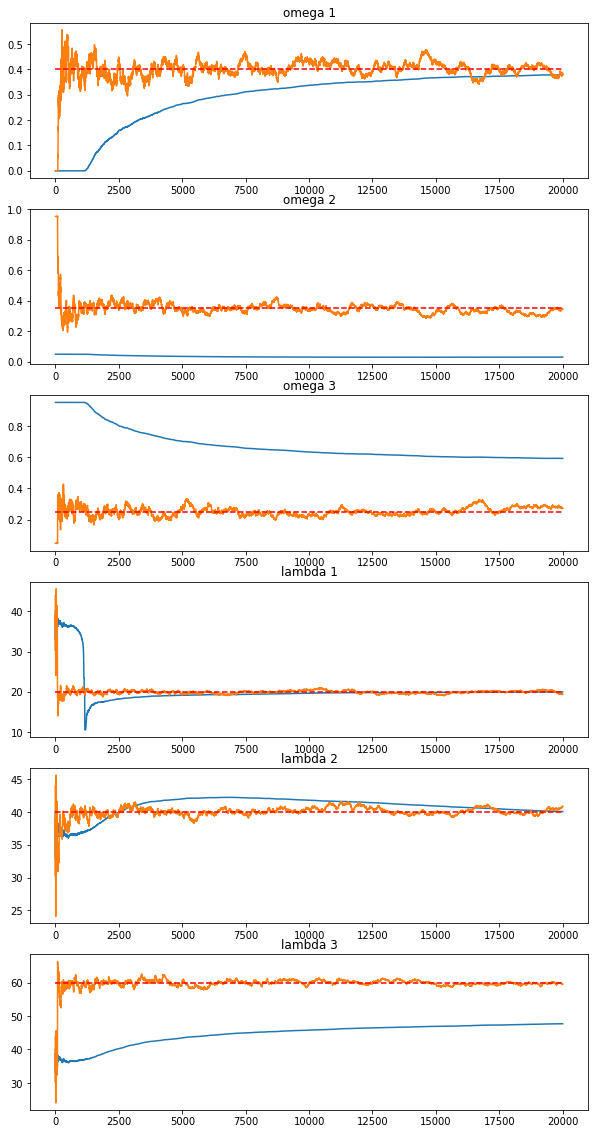

In [157]:
# visualize the process of parameter convergence 
names = ['omega 1','omega 2','omega 3','lambda 1','lambda 2','lambda 3']
truth = change_order(theta_true).reshape((1,-1))[0]

order1 = np.argsort(theta_g1[1,:])
order1 = np.concatenate([order1,order1+3])

order2 = np.argsort(theta_g2[1,:])
order2 = np.concatenate([order2,order2+3])

plt.figure(figsize=(10,20))
for i in range(6):
    plt.subplot(6,1,i+1).set_title(names[i])
    plt.plot(all_theta_g1[1:,order1[i]],label='alpha=1.0')
    plt.plot(all_theta_g2[1:,order2[i]],label='alpha=0.6')
    plt.plot([1,n],[truth[i],truth[i]],'r--',label='Truth')
#     if i<3:
#         plt.ylim(0.,1.)
#     else:
#         plt.ylim(0,max_l+10)
    #plt.plot(all_theta_g3[1:,0],label='alpha=0.3')
#     plt.legend()

### Online EM [Test 2]
Initialization sensitivity 

In [14]:
num_iter = 100
gamma = np.array([gamma_0 * np.power(l, -1.0) for l in range(1, n+1)])
all_theta =[]
for i in range(num_iter):
    p_init, l_init = poisson_random_param(m, max_l)
    theta_init = np.array([p_init, l_init])
    s, theta = online_EM(Y, theta_init, gamma, poisson_s_bar, poisson_theta_bar)
    #print(theta)
    theta = change_order(theta)
    all_theta.append(theta.reshape(1,-1)[0])


In [15]:
all_theta = np.stack(all_theta,axis=0)
print(all_theta)

[[3.71937216e-01 3.77924309e-01 2.50138475e-01 9.99846976e+00
  3.92369479e+01 8.03219120e+01]
 [4.47096695e-01 3.06454038e-01 2.46449267e-01 1.39343567e+01
  4.09820656e+01 8.05434561e+01]
 [4.01322277e-01 3.52246240e-01 2.46431484e-01 1.12891884e+01
  4.04590552e+01 8.05775580e+01]
 [4.41228539e-01 3.11023787e-01 2.47747674e-01 1.34836788e+01
  4.09499239e+01 8.05384583e+01]
 [3.78348426e-01 2.04582955e-01 4.17068620e-01 1.00967439e+01
  3.74346122e+01 6.51222077e+01]
 [3.79149929e-01 1.83317861e-01 4.37532210e-01 1.00465852e+01
  3.72513510e+01 6.39975739e+01]
 [3.81593520e-01 3.69769516e-01 2.48636964e-01 1.01495951e+01
  3.99194294e+01 8.04586408e+01]
 [3.74932370e-01 3.75665484e-01 2.49402146e-01 1.00324808e+01
  3.94790392e+01 8.03785618e+01]
 [3.79252059e-01 9.78018089e-02 5.22946132e-01 1.00306170e+01
  3.55671869e+01 5.99609228e+01]
 [3.78926761e-01 1.99749535e-01 4.21323704e-01 1.00049797e+01
  3.74171342e+01 6.49709239e+01]
 [4.67127664e-01 2.84228014e-01 2.48644323e-01 1.4

In [16]:
print(np.mean(all_theta,axis=0))
print(np.std(all_theta,axis=0))

[ 0.38053459  0.29843854  0.32102687 11.75672998 37.49824135 74.34193391]
[ 0.13556721  0.09583103  0.13941867  3.07097102 12.12306087  9.18815974]


[ 0.4   0.35  0.25  1.   20.   50.  ]


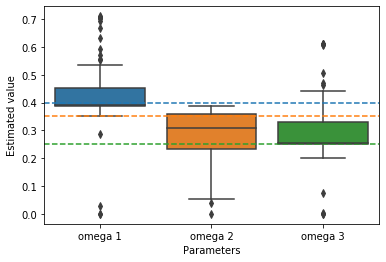

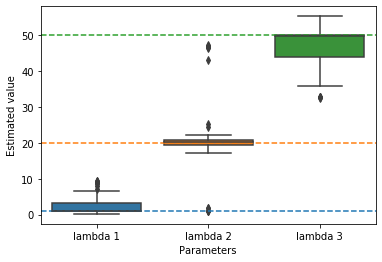

In [244]:
df = pd.DataFrame()
df['Estimated value'] = all_theta.reshape((-1,1))[:,0]
df['Parameters'] = names*num_iter

true_params = change_order(theta_true).reshape((1,-1))[0]
print(true_params)

df_omega =df[df['Parameters'].str.contains('omega')]
df_lambda =df[df['Parameters'].str.contains('lambda')]

plt.figure()
sns.boxplot(x='Parameters',y='Estimated value',data=df_omega)
for i in range(3):
    plt.plot([-0.5,2.5],[true_params[i],true_params[i]],'--')
    
plt.figure()
sns.boxplot(x='Parameters',y='Estimated value',data=df_lambda)
for i in range(3,6):
    plt.plot([-0.5,2.5],[true_params[i],true_params[i]],'--')

## Online EM [Test3]
Compare onlie em with Titterington and batch em

In [10]:
# online em (alpha =1)
num_iter = 10
gamma_0 = 1
alpha = 1.
gamma = np.array([gamma_0 * np.power(l, -alpha) for l in range(1, n+1)])
all_theta_1 =[]

for i in range(num_iter):
    p_init, l_init = poisson_random_param(m, max_l)
    theta_init = np.array([p_init, l_init])
    s, theta = online_EM(Y, theta_init, gamma, poisson_s_bar, poisson_theta_bar)
    #print(theta)
    theta = change_order(theta)
    all_theta_1.append(theta.reshape(1,-1)[0])


In [11]:
# online em (alpha =0.6)
num_iter = 10
gamma_0 = 1
alpha = 0.6
gamma = np.array([gamma_0 * np.power(l, -alpha) for l in range(1, n+1)])
all_theta_06 =[]

for i in range(num_iter):
    p_init, l_init = poisson_random_param(m, max_l)
    theta_init = np.array([p_init, l_init])
    s, theta = online_EM(Y, theta_init, gamma, poisson_s_bar, poisson_theta_bar)
    #print(theta)
    theta = change_order(theta)
    all_theta_06.append(theta.reshape(1,-1)[0])

In [ ]:
# online em2 
num_iter = 100
gamma_0 = 1
alpha = 1.
gamma = np.array([gamma_0 * np.power(l, -alpha) for l in range(1, n+1)])
all_theta_2 =[]
p_init, l_init = poisson_random_param(m, max_l)
theta_init = np.array([p_init, l_init])
s, theta = online_EM2(Y, theta_init, gamma)
print(theta)
for i in range(num_iter):
    p_init, l_init = poisson_random_param(m, max_l)
    theta_init = np.array([p_init, l_init])
    s, theta = online_EM2(Y, theta_init, gamma)
    #print(theta)
    theta = change_order(theta)
    all_theta_2.append(theta.reshape(1,-1)[0])

In [12]:
# batch em 
num_iter = 10
gamma_0 = 1
alpha = 1.
gamma = np.array([gamma_0 * np.power(l, -alpha) for l in range(1, n+1)])
all_theta_batch =[]

max_iteration =5
for i in range(num_iter):
    p_init, l_init = poisson_random_param(m, max_l)
    theta_init = np.array([p_init, l_init])
    theta = batch_EM(Y, theta_init,max_iter = max_iteration)
    #print(theta)
    theta = change_order(theta)
    all_theta_batch.append(theta.reshape(1,-1)[0])

In [13]:
all_theta_1 = np.stack(all_theta_1,axis=0)
print(all_theta_1.shape)
all_theta_06 = np.stack(all_theta_06,axis=0)
all_theta_batch = np.stack(all_theta_batch,axis=0)

(10, 6)


In [14]:
true_params = change_order(theta_true).reshape((1,-1))[0]
print(true_params)

[ 0.4   0.35  0.25 10.   30.   50.  ]


In [15]:
all_theta =np.concatenate([all_theta_1,all_theta_06,all_theta_batch],axis=0)
print(all_theta.shape)

(30, 6)


In [16]:
methods = ['OL1']*num_iter + ['OL06']*num_iter +['EM5']*num_iter
params = ['Omega 1','Omega 2','Omega 3','Lambda 1','Lambda 2','Lambda 3']

In [17]:
df = pd.DataFrame(all_theta,columns=params)
df['Methods'] = methods

In [18]:
print(df)

     Omega 1   Omega 2   Omega 3   Lambda 1   Lambda 2   Lambda 3 Methods
0   0.393135  0.360638  0.246228   9.955339  29.822031  50.029982     OL1
1   0.390400  0.217171  0.392429   9.905212  26.978546  43.986424     OL1
2   0.522894  0.000242  0.476865  13.667710  27.205001  41.592863     OL1
3   0.394774  0.113140  0.492086   9.993781  25.133126  41.046969     OL1
4   0.522810  0.000037  0.477154  13.663969  27.239367  41.585856     OL1
5   0.398024  0.374815  0.227161  10.025838  30.583833  50.773189     OL1
6   0.391715  0.354180  0.254106   9.931955  29.542288  49.718409     OL1
7   0.395666  0.125302  0.479032  10.000617  25.510811  41.404409     OL1
8   0.391410  0.020262  0.588328  10.374855  10.423868  38.610198     OL1
9   0.445969  0.317984  0.236048  11.575182  31.342107  50.240108     OL1
10  0.411852  0.335458  0.252689   9.839042  29.949673  49.794430    OL06
11  0.411852  0.335458  0.252689   9.839042  29.949673  49.794430    OL06
12  0.411852  0.335458  0.252689   9.8

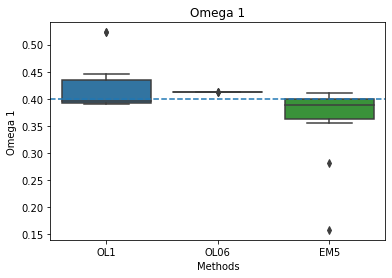

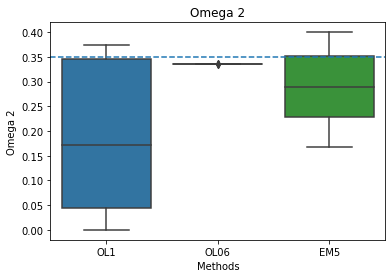

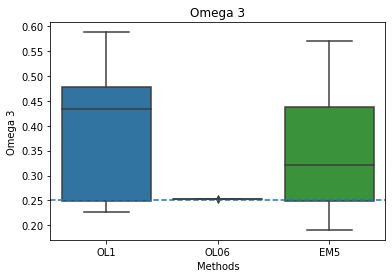

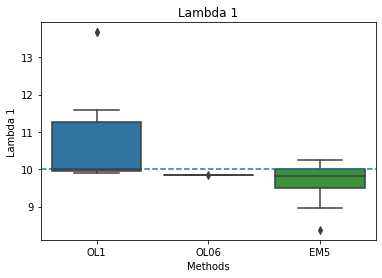

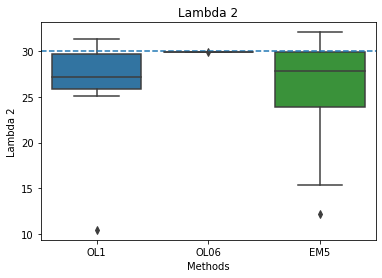

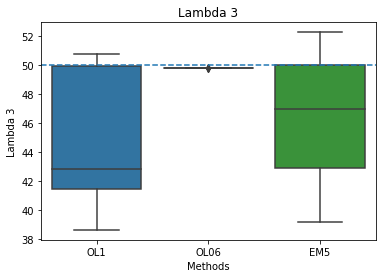

In [19]:
count = 0 

for param in params:
    plt.figure()
    sns.boxplot(x='Methods',y=param,data=df)
    plt.plot([-0.5,2.5],[true_params[count],true_params[count]],'--')
    plt.title(param)
    #if count<3:
        #plt.ylim(0.,1.)
    #else:
        #plt.ylim(0,max_l+10)
    count+=1